# Predictive Analytics for Energy Efficiency Integrating LSTM and Apache Spark for Occupancy Estimation

In [1]:
# Due the different version of python can be found and each machine or libriries 
# I just decided to use this library to avoid distraction and anoing warnigs
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

## Licence of use

Working with Room Occupancy Estimation: That dataset was collected from UCI Machine Learning Repository -https://archive.ics.uci.edu/dataset/864/room+occupancy+estimation
licence by Creative Commons Attribution 4.0 (CC BY 4.0) https://creativecommons.org/licenses/by/4.0/

## About the dataset

    -> The experimental testbed for occupancy estimation was deployed in a 6m x 4.6m room. The setup consisted of 7 sensor nodes and one edge node in a star configuration with the sensor nodes transmitting data to the edge every 30s using wireless transceivers.
    -> The data was collected for a period of 4 days in a controlled manner with the occupancy in the room varying between 0 and 3 people. The ground truth of the occupancy count in the room was noted manually.

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local") \
    .appName("Occupancy Estimation") \
    .getOrCreate()

24/04/06 15:49:35 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
# Loading dataset from HDFS - Biga data Tecnology to storage
df = spark.read.csv("hdfs:///user1/Occupancy_Estimation.csv", header=True, inferSchema=True)

# Preprocessing the dataset with PySpark 
    
     - EDA
     - Cleaning features that won't be used by the LSTM --> Feature Engineering
     - Converting to a Pandas Df to preprocecing
     - Normalization

In [5]:
# Print the schema to understand the data types
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- S1_Temp: double (nullable = true)
 |-- S2_Temp: double (nullable = true)
 |-- S3_Temp: double (nullable = true)
 |-- S4_Temp: double (nullable = true)
 |-- S1_Light: integer (nullable = true)
 |-- S2_Light: integer (nullable = true)
 |-- S3_Light: integer (nullable = true)
 |-- S4_Light: integer (nullable = true)
 |-- S1_Sound: double (nullable = true)
 |-- S2_Sound: double (nullable = true)
 |-- S3_Sound: double (nullable = true)
 |-- S4_Sound: double (nullable = true)
 |-- S5_CO2: integer (nullable = true)
 |-- S5_CO2_Slope: double (nullable = true)
 |-- S6_PIR: integer (nullable = true)
 |-- S7_PIR: integer (nullable = true)
 |-- Room_Occupancy_Count: integer (nullable = true)



In [6]:
from pyspark.sql import SparkSession
# Assuming df is your Spark DataFrame

# Convert Spark DataFrame summary statistics to a Pandas DataFrame
pandas_df_summary = df.describe().toPandas()

# Use IPython display for prettier output (ideal for Jupyter notebooks)
from IPython.display import display
display(pandas_df_summary)

# For custom formatting (e.g., setting decimal precision)
pandas_df_summary.style.format("{:.2f}");

24/04/06 15:49:49 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,Date,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,count,10129,10129,10129,10129,10129,10129,10129,10129,10129,10129,10129,10129,10129,10129,10129,10129,10129,10129
1,mean,None,25.454012242078203,25.54605884095266,25.056620594333857,25.754124790207086,25.445058742225292,26.016289860795734,34.24849442195676,13.22025866324415,0.16817751011942533,0.12006614670744918,0.15811926152627273,0.10384045809063676,460.860400829302,-0.00483000068350229,0.09013722973640044,0.07957350182643894,0.3985585941356501
2,stddev,None,0.351350551388067,0.5863254509673754,0.42728250832189574,0.356434071686561,51.01126404586223,67.30417025816692,58.40074377922952,19.60221922917804,0.3167091032568891,0.266502502233752,0.4136366134889066,0.12068279538984712,199.96493980975043,1.1649895813031426,0.2863924006559917,0.2706451389275408,0.8936330738301977
3,min,2017/12/22,24.94,24.75,24.44,24.94,0,0,0,0,0.06,0.04,0.04,0.05,345,-6.29615384615,0,0,0
4,max,2018/01/11,26.38,29.0,26.19,26.56,165,258,280,74,3.88,3.44,3.67,3.4,1270,8.98076923077,1,1,3


In [7]:
from pyspark.sql.functions import col, count

# Count the total number of entries
total_entries = df.count()

# Count the number of non-null (non-missing) values in each column
non_missing_counts = df.agg(*(count(c).alias(c) for c in df.columns))

# To view the results
non_missing_counts.show()

# Calculating missing values by subtracting non-missing from total entries
# This involves converting the DataFrame to a Pandas DataFrame for easier manipulation
non_missing_counts_pandas = non_missing_counts.toPandas()
missing_values = total_entries - non_missing_counts_pandas.iloc[0]
print("Missing values in each column:\n", missing_values)


+-----+-----+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------+------------+------+------+--------------------+
| Date| Time|S1_Temp|S2_Temp|S3_Temp|S4_Temp|S1_Light|S2_Light|S3_Light|S4_Light|S1_Sound|S2_Sound|S3_Sound|S4_Sound|S5_CO2|S5_CO2_Slope|S6_PIR|S7_PIR|Room_Occupancy_Count|
+-----+-----+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------+------------+------+------+--------------------+
|10129|10129|  10129|  10129|  10129|  10129|   10129|   10129|   10129|   10129|   10129|   10129|   10129|   10129| 10129|       10129| 10129| 10129|               10129|
+-----+-----+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------+------------+------+------+--------------------+

Missing values in each column:
 Date                    0
Time                    0
S1_Temp                 0
S2_Temp                 

## Correlation and time steps

    Each observation in this dataset was measured every 30 seconds, in order to capture trends or patterns
    within a 30-minute window, has to follow the formula.
- ##### (30 × 60) ÷ 30 = <code>60 time steps.</code> (reading is 30min times 60 seconds divided by 30 seconds)

In [8]:
# Converting the Full spark data set to pandas making a copy
df_spk = spark.read.csv("hdfs:///user1/Occupancy_Estimation.csv", header=True, inferSchema=True)

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# List of sensor columns to correlate with 'Room_Occupancy_Count'
sensor_columns = [
    "S1_Temp", "S2_Temp", "S3_Temp", "S4_Temp",
    "S1_Light", "S2_Light", "S3_Light", "S4_Light",
    "S1_Sound", "S2_Sound", "S3_Sound", "S4_Sound",
    "S5_CO2", "S5_CO2_Slope", "S6_PIR", "S7_PIR"
]

# Dictionary to store the correlation values
correlations = {}

# Calculate correlation for each sensor and store it
for sensor in sensor_columns:
    correlation = df_spk.stat.corr(sensor, "Room_Occupancy_Count")
    correlations[sensor] = correlation

# Find the maximum correlation
max_correlation_value = max(correlations.values())
max_correlation_sensor = [sensor for sensor, corr in correlations.items() if corr == max_correlation_value][0]

# Highlight the maximum correlation in the output
for sensor, correlation in correlations.items():
    if sensor == max_correlation_sensor:
        # Using ANSI escape codes for colors: \033[1m for bold, \033[92m for green, \033[0m to reset
        print(f"\033[1m\033[92mHighest Correlation between {sensor} and Room_Occupancy_Count: {correlation}\033[0m")
    else:
        print(f"Correlation between {sensor} and Room_Occupancy_Count: {correlation}")


Correlation between S1_Temp and Room_Occupancy_Count: 0.7008681816112686
Correlation between S2_Temp and Room_Occupancy_Count: 0.6712634874724777
Correlation between S3_Temp and Room_Occupancy_Count: 0.6520465675239043
Correlation between S4_Temp and Room_Occupancy_Count: 0.5265086555834034
Highest Correlation between S1_Light and Room_Occupancy_Count: 0.8490580523038589
Correlation between S2_Light and Room_Occupancy_Count: 0.788763877382767
Correlation between S3_Light and Room_Occupancy_Count: 0.7930813168051819
Correlation between S4_Light and Room_Occupancy_Count: 0.3557147404498904
Correlation between S1_Sound and Room_Occupancy_Count: 0.5737482916455339
Correlation between S2_Sound and Room_Occupancy_Count: 0.5578530448115523
Correlation between S3_Sound and Room_Occupancy_Count: 0.5316848559795653
Correlation between S4_Sound and Room_Occupancy_Count: 0.46028734590084147
Correlation between S5_CO2 and Room_Occupancy_Count: 0.6601444951524897
Correlation between S5_CO2_Slope and

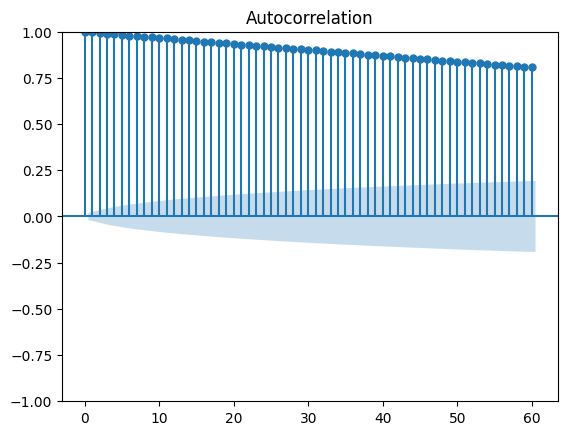

In [15]:
# This line should be run after the creation of data sets on next step
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# `pandas_target_df` is a Pandas df before normalization of target variable
plot_acf(pandas_target_df, lags=60)
plt.show()

# Features and Target

 - Target is predict Room Ocuppancy which is(Room_Occupancy_Count)
 - All the sensors readings would be the features to be analysed
 - Let's perform a better Feature Engineering - separating onto differents df

In [11]:
# Separating features and target variable - This step here it's just to don't go and just drop features.just to use the most correlated feature
# Select only the 'S1_Light' column as the feature
features_df = df.select('S1_Light')

# Select 'Room_Occupancy_Count' as the target
target_df = df.select('Room_Occupancy_Count')


In [12]:
# features_df and target_df are a Spark DataFrames also, convert those to Pandas for normalization(Features)
pandas_features_df = features_df.toPandas()
pandas_target_df = target_df.toPandas()

In [13]:
# One-hot encode the target variable to perform classification to a categorical format
pandas_target_df_categorical = pd.get_dummies(pandas_target_df['Room_Occupancy_Count'])

In [14]:
# Normalize the feature data
scaler_features = MinMaxScaler(feature_range=(0, 1))
pandas_features_df_scaled = pd.DataFrame(scaler_features.fit_transform(pandas_features_df),
                                         columns=pandas_features_df.columns)

## Preparation to aproach  a LSTM model

    Transforming feature and target data into sequences as we have time series data.
    This process involves using all data available to create sequences that LSTM model can learn from it.

In [16]:
# Function to create sequences
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [17]:
# Create sequences using the scaled features and one-hot encoded target
time_steps = 60
X, y = create_sequences(pandas_features_df_scaled, pandas_target_df_categorical.values, time_steps=time_steps)

In [18]:
# Splitting time series data for LSTM models, ensuring the split preserves the sequence's temporal order
# Determine the split point for an 80/20 train-test split

# Split the data into training and testing sets
split_point = int(len(X) * 0.8)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

In [19]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8055, 60, 1) (8055, 4) (2014, 60, 1) (2014, 4)


In [20]:
# this step here it's needed in order to address class imbalance that was noticed during the experimentation fase
# Using Smote technique
from imblearn.over_sampling import SMOTE
import numpy as np

# Reshape the data from 3D to 2D
nsamples, nx, ny = X_train.shape
X_train_2d = X_train.reshape((nsamples, nx*ny))

# Apply SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_2d, y_train)

# Reshape the data back to 3D
X_train_smote_3d = X_train_smote.reshape((-1, nx, ny))

# LSTM model architecture

In [21]:
# Define the LSTM model for classification
model = Sequential([
    LSTM(80, activation='relu', input_shape=(X_train_smote_3d.shape[1], X_train_smote_3d.shape[2])),
    Dense(4, activation='softmax')  # 4 output units for 4 classes (0, 1, 2, 3)
])

# Compile the model with categorical crossentropy loss and accuracy metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the SMOTE-resampled dataset
history = model.fit(X_train_smote_3d, y_train_smote, epochs=25, batch_size=20, validation_split=0.1, verbose=1)


Epoch 1/25
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5754 - loss: 1.6208 - val_accuracy: 0.0000e+00 - val_loss: 1.4067
Epoch 2/25
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6012 - loss: 1.0208 - val_accuracy: 0.6341 - val_loss: 0.9648
Epoch 3/25
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6983 - loss: 0.6921 - val_accuracy: 0.6318 - val_loss: 0.9029
Epoch 4/25
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7009 - loss: 0.6732 - val_accuracy: 0.5832 - val_loss: 0.9408
Epoch 5/25
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7028 - loss: 0.6168 - val_accuracy: 0.6326 - val_loss: 0.9330
Epoch 6/25
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7343 - loss: 0.5526 - val_accuracy: 0.5893 - val_loss: 0.8804
Epoch 7/25
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7178 - loss: 0.7071 - val_accuracy: 0.6974 - val_loss: 0.8465
Epoch 8/25
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7581 - loss

### Evaluating on the test set

In [22]:
test_loss, test_accuracy = model.evaluate(X_train_smote_3d, y_train_smote)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

810/810 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9524 - loss: 0.2040
Test Accuracy: 91.49%


In [23]:
# Predict and convert probabilities to class labels
y_pred_proba = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_proba, axis=1)

#Convert true labels from one-hot encoding to class labels for comparison
y_true_labels = np.argmax(y_test, axis=1)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [24]:
# Analyzing the results using confusion matrix, classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true_labels, y_pred_labels))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1751
           1       0.00      0.00      0.00         0
           2       1.00      0.03      0.06        93
           3       0.18      0.08      0.11       170

    accuracy                           0.87      2014
   macro avg       0.53      0.28      0.28      2014
weighted avg       0.86      0.87      0.85      2014



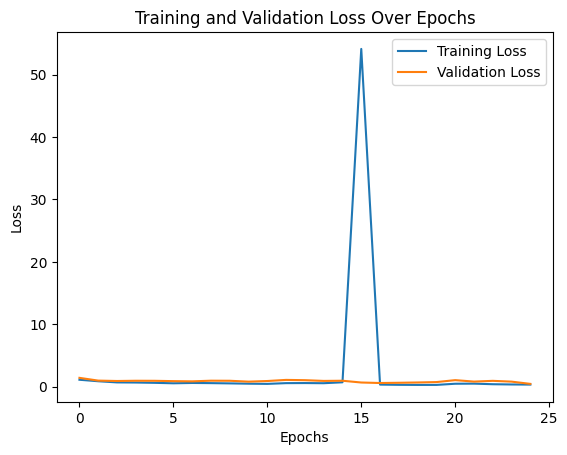

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

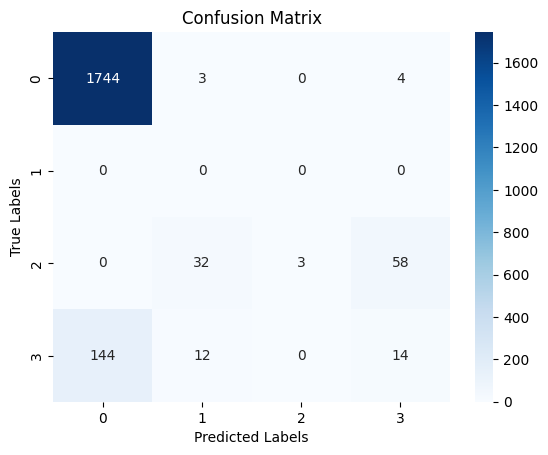

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()